In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Add XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [58]:

df = pd.read_csv('data.csv')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103392 entries, 0 to 103391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time            103392 non-null  object 
 1   ptime           103392 non-null  object 
 2   wind_direction  103392 non-null  float64
 3   wind_speed      103392 non-null  float64
 4   temperature     102816 non-null  float64
 5   pressure        102816 non-null  float64
 6   power           99734 non-null   float64
dtypes: float64(5), object(2)
memory usage: 5.5+ MB


In [60]:
df.head(5)

,time,ptime,wind_direction,wind_speed,temperature,pressure,power
0,2019-01-01 00:00:00,2018-12-31 06:00:00,293.198308,9.004684,275.698962,103353.718750,2707.0
1,2019-01-01 00:15:00,2018-12-31 06:00:00,292.102529,8.847332,275.636830,103343.753906,2749.0
2,2019-01-01 00:30:00,2018-12-31 06:00:00,291.005947,8.689980,275.574697,103333.789062,2566.0
3,2019-01-01 00:45:00,2018-12-31 06:00:00,289.909365,8.532627,275.512564,103323.824219,2613.0
4,2019-01-01 01:00:00,2018-12-31 06:00:00,288.813586,8.375275,275.450431,103313.859375,2602.0


In [61]:
missing_values = df.isnull().sum()
missing_values

time                 0
ptime                0
wind_direction       0
wind_speed           0
temperature        576
pressure           576
power             3658
dtype: int64

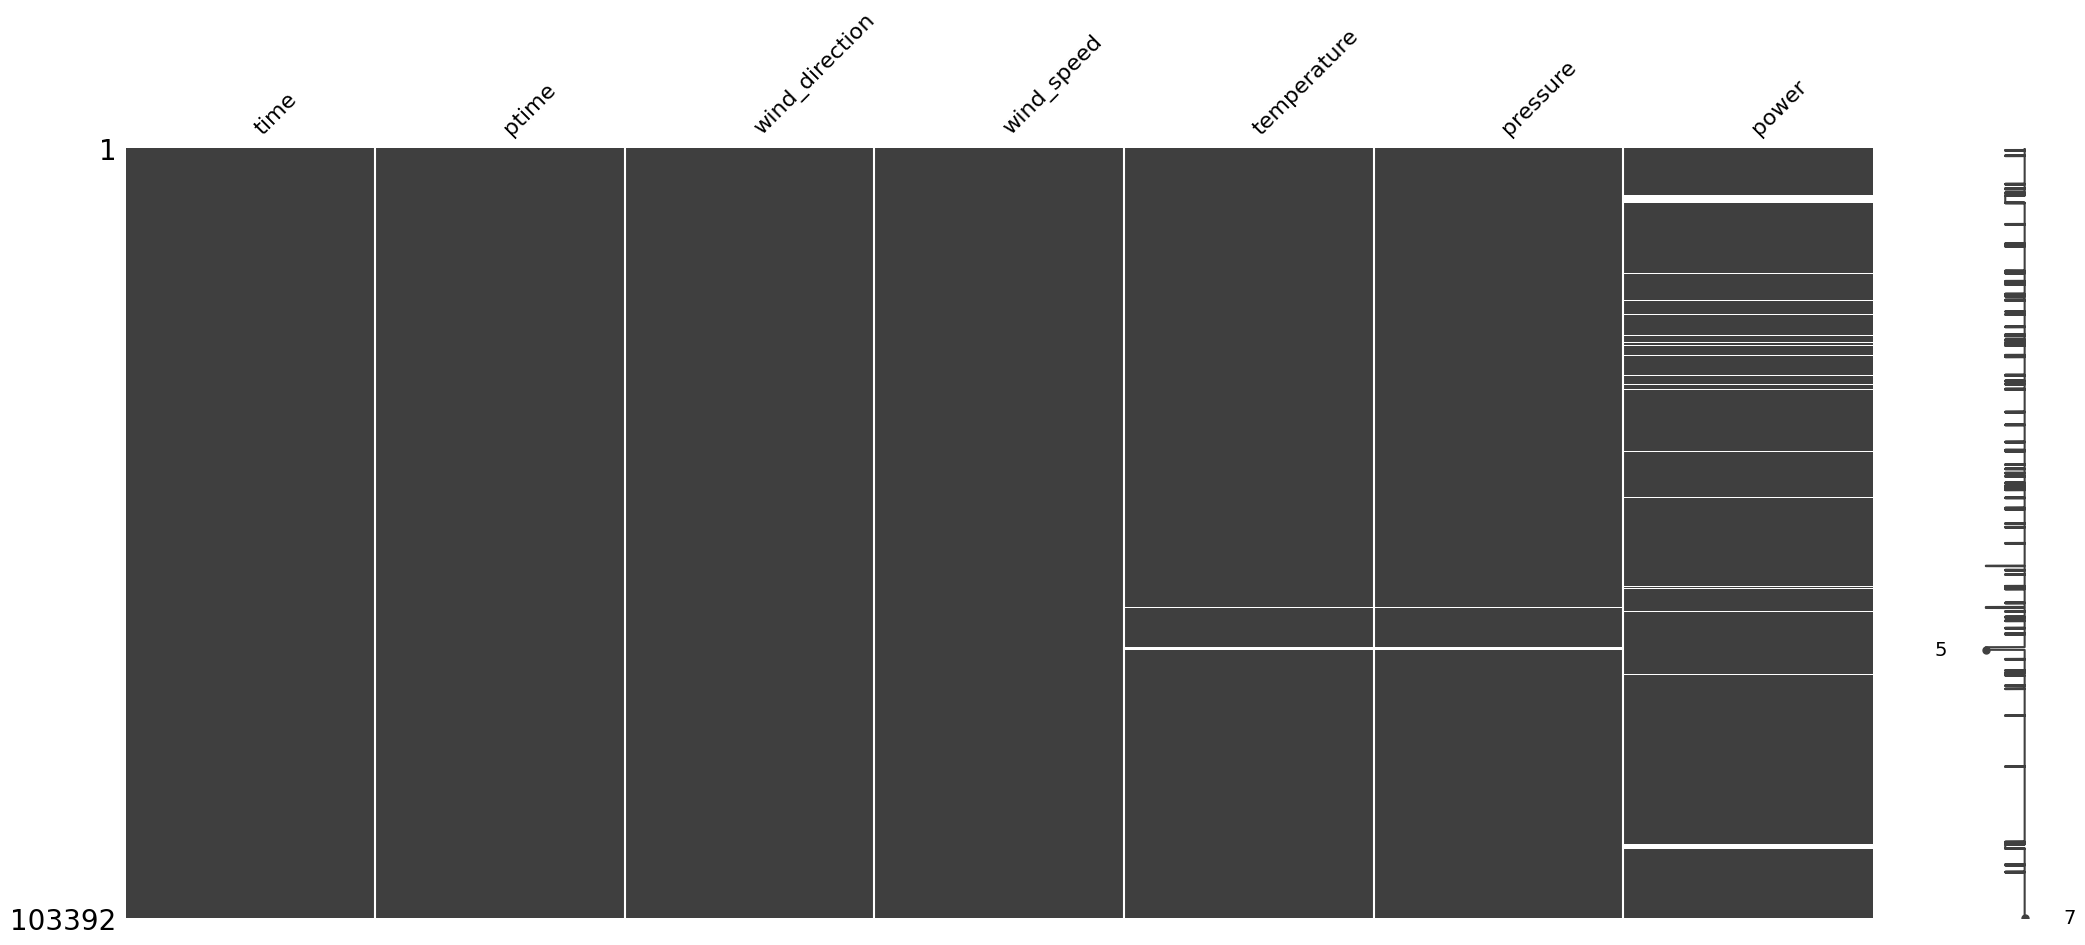

In [62]:
msno.matrix(df)
plt.show()


Da die fehlenden Daten (Druck und Temperatur) nicht zufällig sind, habe ich beobachtet, dass die Temperatur und der Druck das gleiche Muster fehlender Werte aufweisen. Daher würde ich in diesem Fall keine Mittelwert- oder Median-Imputation bevorzugen.

Stattdessen würde ich mich für die lineare Interpolationstechnik entscheiden, um die fehlenden Werte aufzufüllen, da es sich bei den Daten um Zeitreihen mit einem hochfrequenten Intervall von 15 Minuten handelt. Ein wesentlicher Vorteil der Interpolation ist, dass der Trend der Daten erhalten bleibt. Darüber hinaus kann die Vorwärts- und Rückwärtsauffüllung manchmal geeignet sein, um fehlende Werte für Zeitreihendaten zu ergänzen.

Anstatt das Modell jedoch nur auf der Grundlage dieser Imputationstechnik zu validieren, beabsichtige ich, seine Leistung zu bewerten, indem ich sowohl Vorwärts- und Rückwärtsfüllung als auch lineare Interpolation verwende. Dieser Ansatz wird dazu beitragen, die effektivste Methode für den Umgang mit fehlenden Werten im Datensatz zu ermitteln.

Da diese Daten für das Modelltraining verwendet werden sollen, wäre das Entfernen der Zeilen mit fehlenden „Power“-Werten die beste Option.
Es ist auch sehr wichtig, die Ursache für die fehlenden Werte zu finden. 
Es könnte sich um Sensorfehlfunktionen, Kommunikationsprobleme oder andere Probleme handeln.

In [63]:
df_cleaned = df.dropna(subset=['power'])
df_cleaned['temperature'].interpolate(inplace=True) 
df_cleaned['pressure'].interpolate(inplace=True)


print(df_cleaned.isnull().sum())

time              0
ptime             0
wind_direction    0
wind_speed        0
temperature       0
pressure          0
power             0
dtype: int64


/tmp/ipykernel_45822/2805214582.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['temperature'].interpolate(inplace=True)
/tmp/ipykernel_45822/2805214582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['temperature'].interpolate(inplace=True)
/tmp/ipykernel_45822/2805214582.py:3: FutureWarning: A value is trying to

In [64]:
df_cleaned['ptime'] = pd.to_datetime(df_cleaned['ptime'], errors='coerce')

/tmp/ipykernel_45822/3319297912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ptime'] = pd.to_datetime(df_cleaned['ptime'], errors='coerce')


In [65]:
df_cleaned["time"] = pd.to_datetime(df_cleaned["time"])
df_cleaned.set_index("time", inplace=True)
df_hourly = df_cleaned.resample("1D").mean()
df_hourly.reset_index(inplace=True)

print(df_hourly.head())

        time                         ptime  wind_direction  wind_speed  \
0 2019-01-01 2018-12-31 21:00:00.000000000      275.533202   11.588646   
1 2019-01-02 2019-01-01 21:55:51.724137728      313.469128   11.976036   
2 2019-01-03 2019-01-02 21:00:00.000000000      304.501917    7.583021   
3 2019-01-04 2019-01-03 20:54:11.612903168      292.984274    8.612425   
4 2019-01-05 2019-01-04 21:00:00.000000000      284.051267   13.691578   

   temperature       pressure        power  
0   274.931052  102829.531942  7507.229167  
1   271.585685  103019.157560  8522.229885  
2   269.449376  103671.525472  5151.031250  
3   270.506826  103472.493581  5588.365591  
4   272.621980  102751.132216  8727.739583  


/tmp/ipykernel_45822/2036309236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["time"] = pd.to_datetime(df_cleaned["time"])


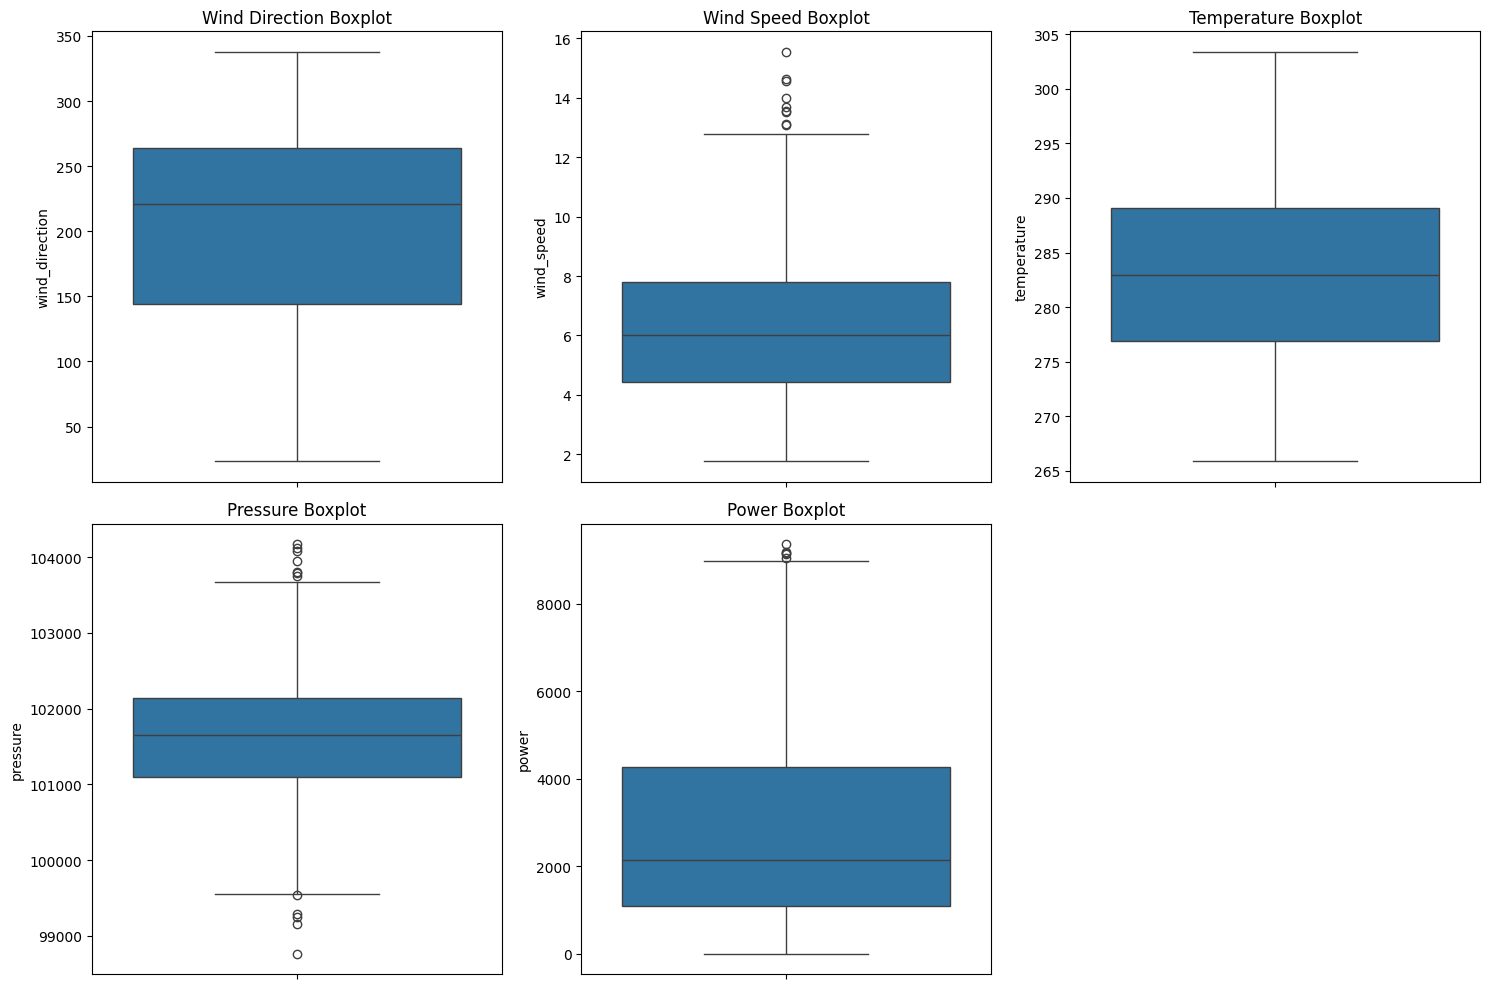

In [66]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(y=df_hourly['wind_direction'])
plt.title('Wind Direction Boxplot')

plt.subplot(2, 3, 2)
sns.boxplot(y=df_hourly['wind_speed'])
plt.title('Wind Speed Boxplot')

plt.subplot(2, 3, 3)
sns.boxplot(y=df_hourly['temperature'])
plt.title('Temperature Boxplot')

plt.subplot(2, 3, 4)
sns.boxplot(y=df_hourly['pressure'])
plt.title('Pressure Boxplot')

plt.subplot(2, 3, 5)
sns.boxplot(y=df_hourly['power'])
plt.title('Power Boxplot')

plt.tight_layout()
plt.show()

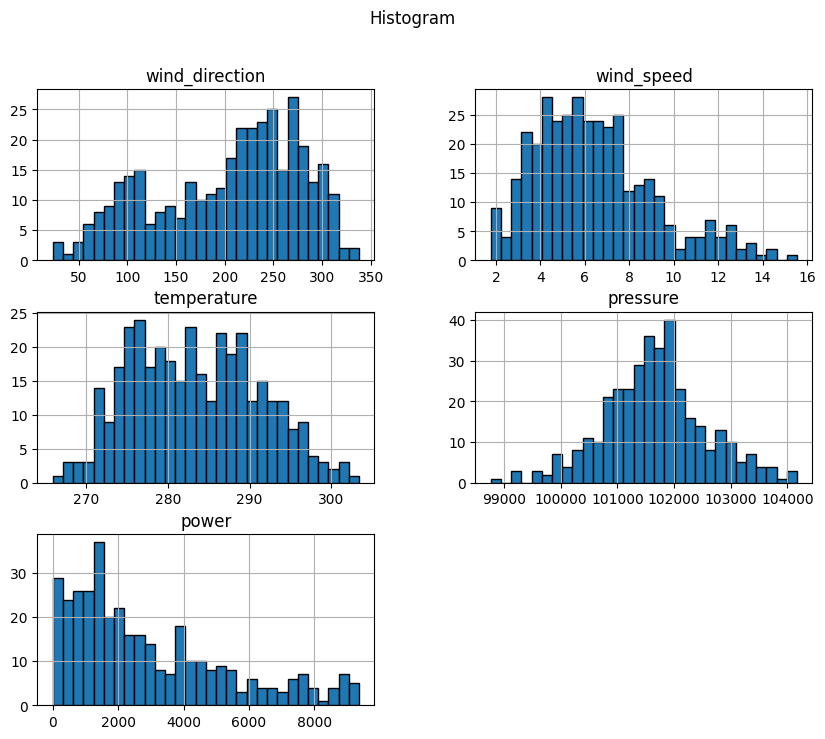

In [67]:
exclude_cols = ["time", "ptime"]
df_hourly_filtered = df_hourly.drop(columns=exclude_cols)

df_hourly_filtered.hist(figsize=(10, 8), bins=30, edgecolor='black')
plt.suptitle("Histogram")
plt.show()



Windrichtung: Scheint eine multimodale Verteilung zu haben, nicht normal.

Windgeschwindigkeit: Rechtsschief (langer Schweif rechts).

Temperatur: Annähernd symmetrisch, aber keine perfekte Normalverteilung.

Druck: Nahezu normal, aber leicht schief.

Leistung: Stark rechtsschief (nicht normal).

Da die Daten nicht normalverteilt zu sein scheinen, werde ich mich darauf konzentrieren, Ausreißer mit Hilfe des Quantilansatzes zu entfernen. Wenn ich jedoch Ausreißer mit der Z-Score-Methode feststellen würde, würde ich die Ausreißer entfernen und dann die Leistung des Modells bewerten. Für die Datenaufbereitung werde ich den Quantilsbereich-Ansatz verwenden, um Ausreißer zu entfernen.

In [68]:
df = df_hourly
df['time'] = pd.to_datetime(df['time'])

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

wind_speed_outliers = detect_outliers_iqr(df, 'wind_speed')
pressure_outliers = detect_outliers_iqr(df, 'pressure')
power_outliers = detect_outliers_iqr(df, 'power')


print("Outlier Analysis:")
print(f"Wind Speed Outliers: {len(wind_speed_outliers)} ({len(wind_speed_outliers) / len(df) * 100:.2f}%)")
print(f"Pressure Outliers: {len(pressure_outliers)} ({len(pressure_outliers) / len(df) * 100:.2f}%)")
print(f"Power Outliers: {len(power_outliers)} ({len(power_outliers) / len(df) * 100:.2f}%)")


power_outliers_index = power_outliers.index
wind_speed_outliers_index = wind_speed_outliers.index

common_index = power_outliers_index.intersection(wind_speed_outliers_index)

print(f'Number of power and wind speed outliers that share the same index: {len(common_index)}')


Outlier Analysis:
Wind Speed Outliers: 9 (2.47%)
Pressure Outliers: 12 (3.29%)
Power Outliers: 5 (1.37%)
Number of power and wind speed outliers that share the same index: 2



Es gab 9 Ausreißer bei der Windgeschwindigkeit (2,47 %), die auf Messfehler des Anemometers zurückgeführt werden konnten. Außerdem wurden 12 Druckausreißer (3,29 %) festgestellt, die möglicherweise auf eine Fehlfunktion des barometrischen Sensors zurückzuführen sind. Darüber hinaus wurden 5 Stromausreißer (1,37 %) festgestellt, die durch plötzliche Stromstöße, Messfehler des Stromzählers oder Turbinenstörungen verursacht worden sein könnten. Es ist sehr wichtig zu untersuchen, ob es sich bei den Ausreißern um gültige Extremereignisse oder um Sensorfehlfunktionen handelt. Daher ist es wichtig, die Wartungsdaten der Windturbine zu haben, die in diesem Szenario fehlen. Ich würde gerne die Wartungsdaten sehen. 

In [69]:
#Combine all outlier indices
outlier_indices = set(wind_speed_outliers.index) | set(pressure_outliers.index) | set(power_outliers.index)

# Remove outliers from the dataset
df_clean = df.drop(index=outlier_indices)

print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_clean.shape[0]}")
print(f"Number of removed outliers: {df.shape[0] - df_clean.shape[0]}")


Original dataset size: 365
Cleaned dataset size: 341
Number of removed outliers: 24


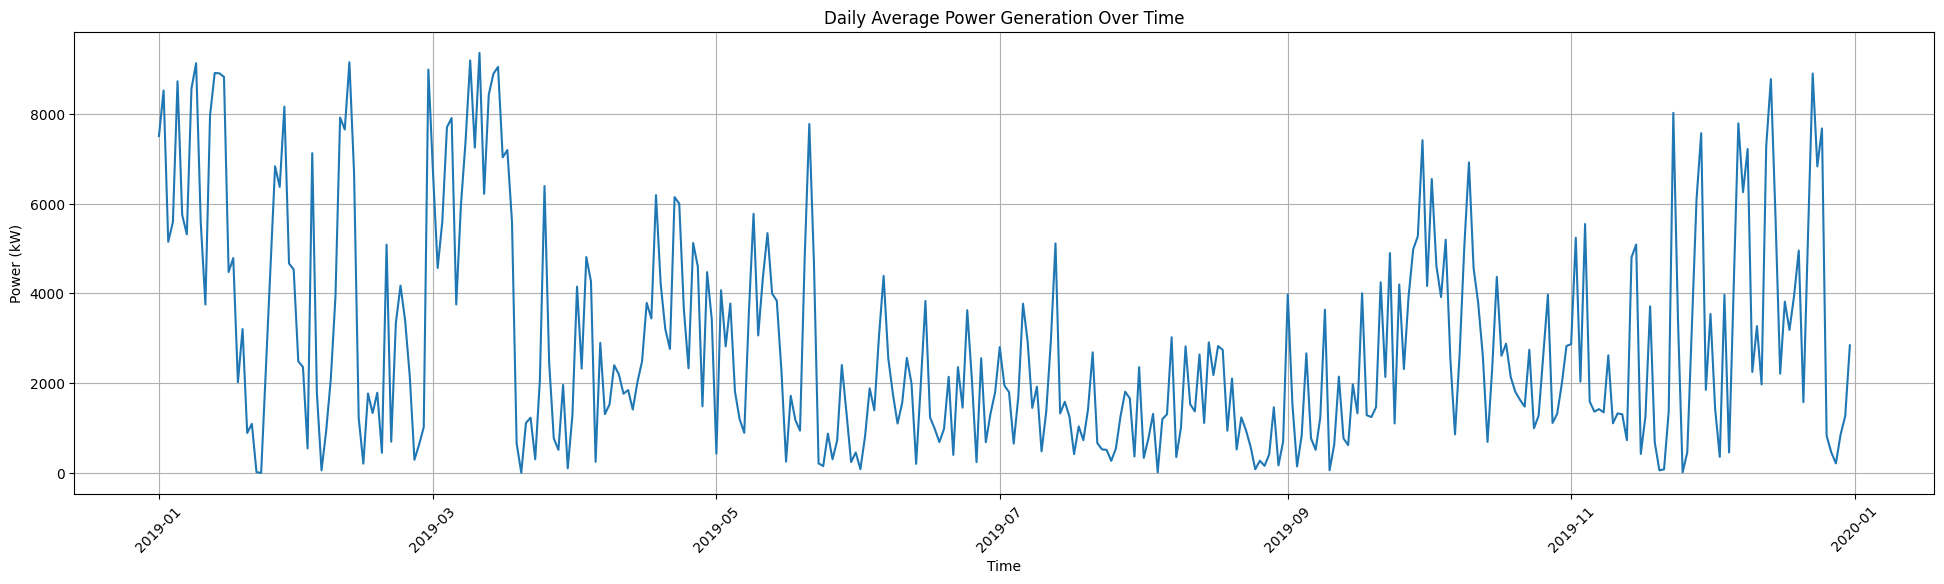

In [70]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=df_hourly['time'], y=df_hourly["power"])
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Daily Average Power Generation Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()

Dieses Diagramm zeigt eindeutig eine saisonale Abhängigkeit. Daher müssen wir beim Entwurf des Datenmodells sicherstellen, dass es dieses saisonale Muster effektiv erfasst.

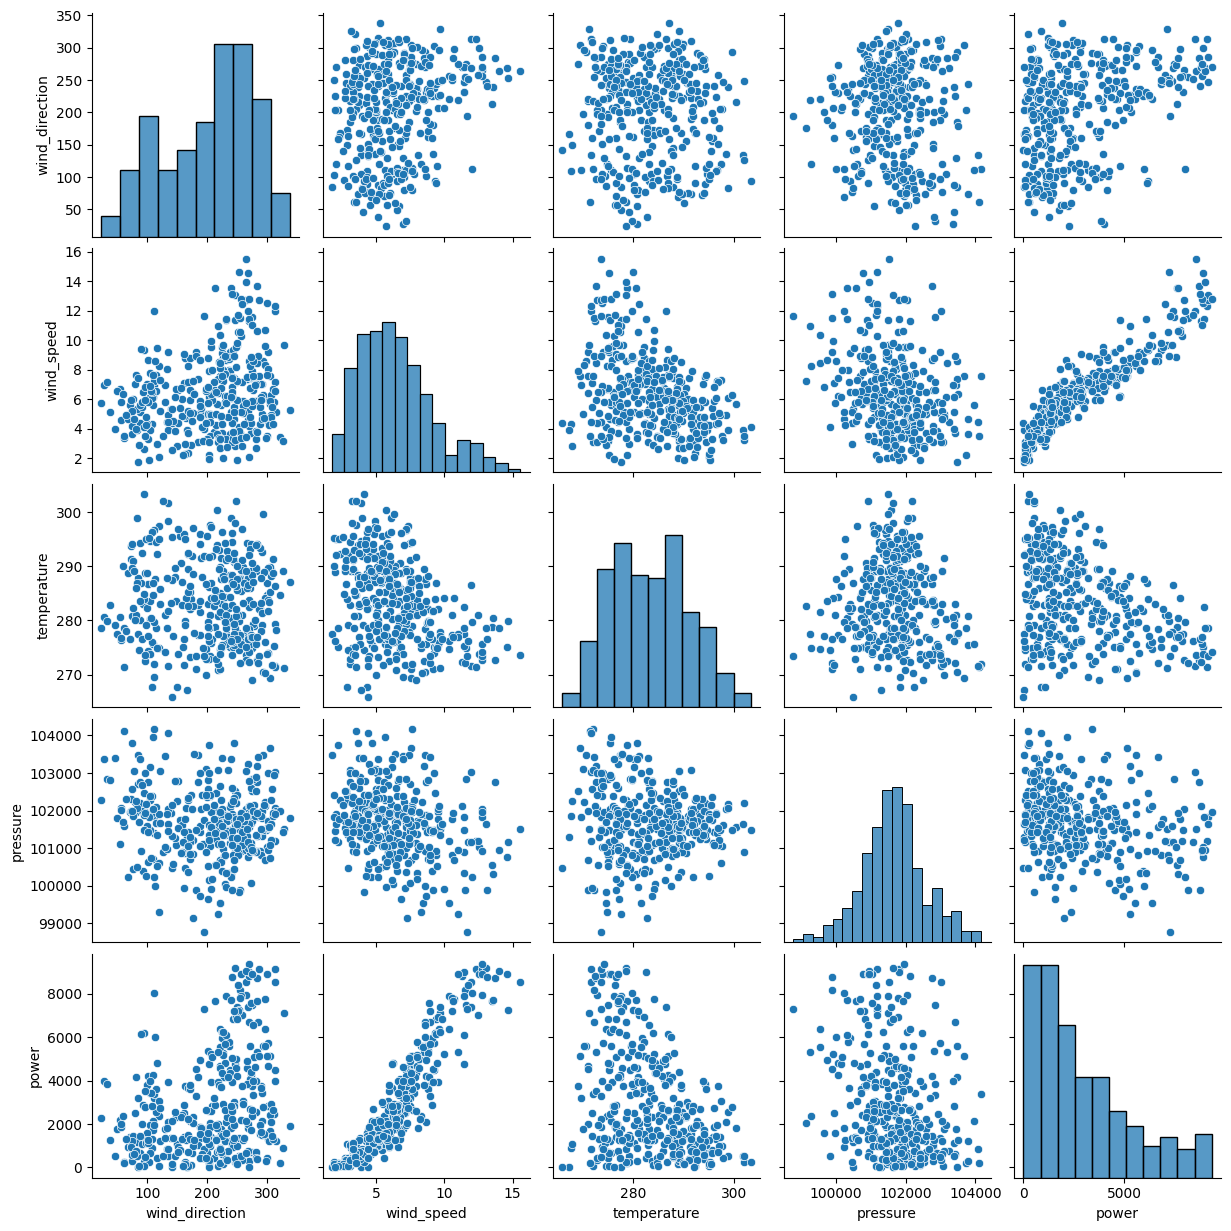

In [71]:
sns.pairplot(df_hourly)
plt.show()

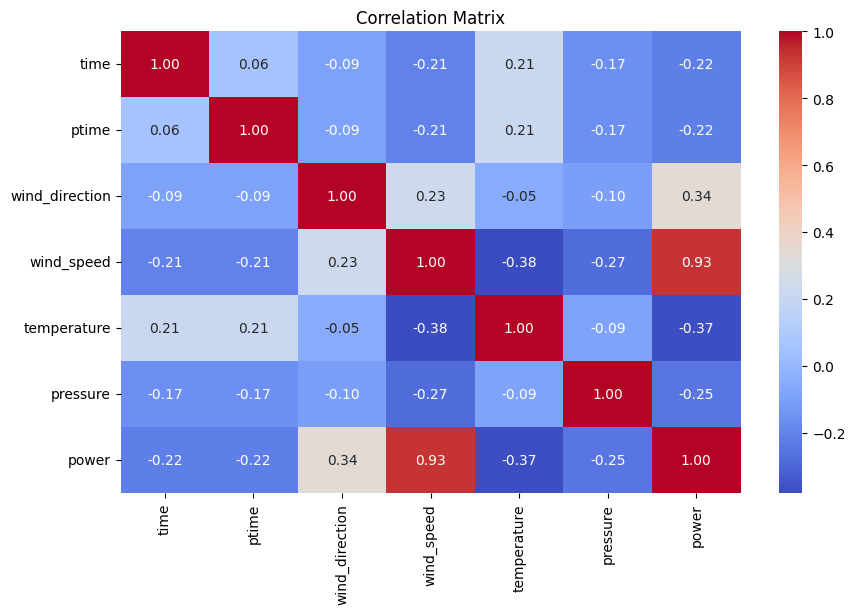

                    time     ptime  wind_direction  wind_speed  temperature  \
time            1.000000  0.057851       -0.094526   -0.206690     0.211815   
ptime           0.057851  1.000000       -0.094502   -0.206662     0.211828   
wind_direction -0.094526 -0.094502        1.000000    0.232450    -0.054456   
wind_speed     -0.206690 -0.206662        0.232450    1.000000    -0.381926   
temperature     0.211815  0.211828       -0.054456   -0.381926     1.000000   
pressure       -0.165187 -0.165191       -0.104728   -0.274823    -0.085363   
power          -0.219786 -0.219756        0.336291    0.932331    -0.372147   

                pressure     power  
time           -0.165187 -0.219786  
ptime          -0.165191 -0.219756  
wind_direction -0.104728  0.336291  
wind_speed     -0.274823  0.932331  
temperature    -0.085363 -0.372147  
pressure        1.000000 -0.248482  
power          -0.248482  1.000000  


In [72]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_hourly.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
print(df_hourly.corr())

In [73]:
df_hourly.head(10)

,time,ptime,wind_direction,wind_speed,temperature,pressure,power
0,2019-01-01,2018-12-31 21:00:00.000000000,275.533202,11.588646,274.931052,102829.531942,7507.229167
1,2019-01-02,2019-01-01 21:55:51.724137728,313.469128,11.976036,271.585685,103019.157560,8522.229885
2,2019-01-03,2019-01-02 21:00:00.000000000,304.501917,7.583021,269.449376,103671.525472,5151.031250
3,2019-01-04,2019-01-03 20:54:11.612903168,292.984274,8.612425,270.506826,103472.493581,5588.365591
4,2019-01-05,2019-01-04 21:00:00.000000000,284.051267,13.691578,272.621980,102751.132216,8727.739583
5,2019-01-06,2019-01-05 21:00:00.000000000,302.045095,9.242556,274.037431,102987.641778,5752.979167
6,2019-01-07,2019-01-06 21:00:00.000000000,283.690190,8.482581,272.563575,103177.424072,5316.145833
7,2019-01-08,2019-01-07 21:00:00.000000000,264.800194,15.548733,273.647660,101510.053372,8564.156250
8,2019-01-09,2019-01-08 21:00:00.000000000,313.722474,12.329643,271.478439,101188.600545,9130.125000
9,2019-01-10,2019-01-09 21:00:00.000000000,296.659824,8.325810,270.240841,102217.754422,5580.802083


In [74]:

# 1. Time-based features
df_hourly['day_of_week'] = df_hourly['ptime'].dt.dayofweek
df_hourly['month'] = df_hourly['ptime'].dt.month
df_hourly['hour'] = df_hourly['ptime'].dt.hour
df_hourly['week_of_year'] = df_hourly['ptime'].dt.isocalendar().week

In [75]:
# Forecast 4 steps (1 hour) ahead
df_hourly['target'] = df_hourly['power'].shift(-1)

Um die saisonalen, täglichen und wöchentlichen Muster zu erfassen, plane ich, Merkmale für den Wochentag, den Monat, die Stunde und die Woche des Jahres zu erstellen. Dies wird dem Modell helfen, saisonale Trends zu erkennen, da wir beobachtet haben, dass die Stromerzeugung im Untergrund mit den Jahreszeiten variiert.

In [76]:
df_hourly.head(5)

,time,ptime,wind_direction,wind_speed,temperature,pressure,power,day_of_week,month,hour,week_of_year,target
0,2019-01-01,2018-12-31 21:00:00.000000000,275.533202,11.588646,274.931052,102829.531942,7507.229167,0.0,12.0,21.0,1,8522.229885
1,2019-01-02,2019-01-01 21:55:51.724137728,313.469128,11.976036,271.585685,103019.157560,8522.229885,1.0,1.0,21.0,1,5151.031250
2,2019-01-03,2019-01-02 21:00:00.000000000,304.501917,7.583021,269.449376,103671.525472,5151.031250,2.0,1.0,21.0,1,5588.365591
3,2019-01-04,2019-01-03 20:54:11.612903168,292.984274,8.612425,270.506826,103472.493581,5588.365591,3.0,1.0,20.0,1,8727.739583
4,2019-01-05,2019-01-04 21:00:00.000000000,284.051267,13.691578,272.621980,102751.132216,8727.739583,4.0,1.0,21.0,1,5752.979167


In [52]:
df_hourly.dropna(inplace=True)

In [53]:
# Separate features and target
X = df_hourly.drop(["power", "target","time","ptime"], axis=1)
y = df_hourly["target"]

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [55]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')


RMSE: 2148.658504546826


/home/mamunds/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [56]:
r2 = r2_score(y_test, y_pred)
print(r2)

0.18928004111489682


In [43]:
df_hourly['wind_direction_sin'] = np.sin(np.radians(df_hourly['wind_direction']))
df_hourly['wind_direction_cos'] = np.cos(np.radians(df_hourly['wind_direction']))

Wenn wir nur die rohen Windrichtungswerte (0-360 Grad) direkt als Merkmale verwenden, würden viele Algorithmen für maschinelles Lernen 360° und 0° als weit voneinander entfernte Punkte interpretieren, obwohl sie denselben physischen Ort (Norden) repräsentieren. Dies würde das Modell verwirren, da es nicht erkennen würde, dass 350° nahe 10° auf dem Kreis liegt.
Um dieses Problem zu vermeiden und die zyklische Beziehung zu erfassen, möchte ich die Windrichtung in zwei Komponenten (Sinus und Kosinus) aufteilen, die die x- und y-Koordinaten auf dem Einheitskreis darstellen.

In [75]:
# Drop the not required column
df_hourly = df_hourly.drop(columns=['ptime', 'time', 'wind_direction'])



In [76]:
## Prepared Data
print(df_hourly.head())

   wind_speed  temperature       pressure        power  day_of_week  month  \
0   11.588646   274.931052  102829.531942  7507.229167          0.0   12.0   
1   11.976036   271.585685  103019.157560  8522.229885          1.0    1.0   
2    7.583021   269.449376  103671.525472  5151.031250          2.0    1.0   
3    8.612425   270.506826  103472.493581  5588.365591          3.0    1.0   
4   13.691578   272.621980  102751.132216  8727.739583          4.0    1.0   

   hour  week_of_year  wind_direction_sin  wind_direction_cos  
0  21.0             1           -0.995340            0.096423  
1  21.0             1           -0.725745            0.687964  
2  21.0             1           -0.824107            0.566434  
3  20.0             1           -0.920612            0.390478  
4  21.0             1           -0.970079            0.242790  


In [77]:
# See total number of NaNs in each column
print(df_hourly.isna().sum())

wind_speed            3
temperature           3
pressure              3
power                 3
day_of_week           3
month                 3
hour                  3
week_of_year          3
wind_direction_sin    3
wind_direction_cos    3
dtype: int64


In [78]:
# Remove any rows that contain NaN values
df_hourly = df_hourly.dropna()


In [79]:
# Separate features and target
X = df_hourly.drop("power", axis=1)
y = df_hourly["power"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)

# Evaluate models
def evaluate_model(name, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.2f}")

evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)
evaluate_model("LightGBM", y_test, lgb_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 289, number of used features: 9
[LightGBM] [Info] Start training from score 2921.503560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/tmp/ipykernel_45822/1614066611.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2022-01-01', periods=24*30, freq='H')  # 30 days hourly
23:40:41 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 0.9500864791207442
R² Score: 0.9293054397551442


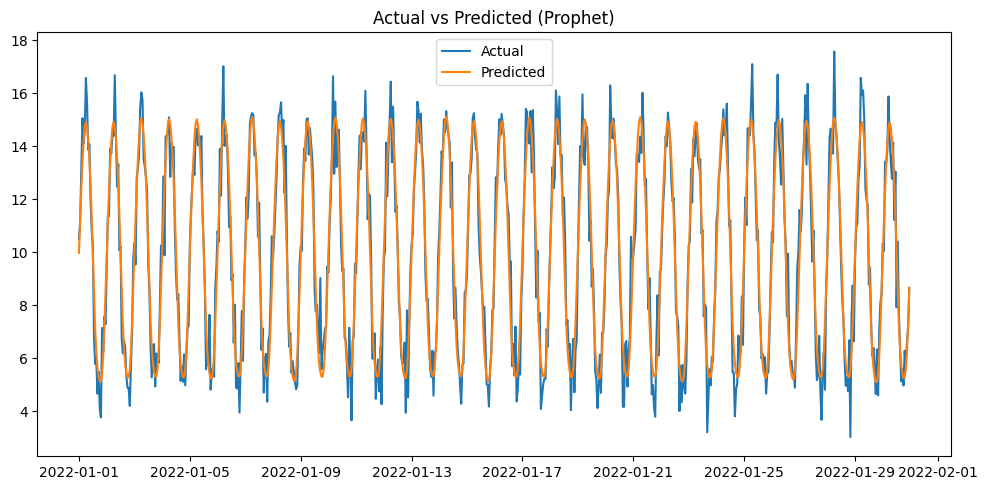

In [80]:
# Install Prophet first if needed:
# pip install prophet

from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Generate synthetic hourly time series data
np.random.seed(42)
date_range = pd.date_range(start='2022-01-01', periods=24*30, freq='H')  # 30 days hourly
y_values = 10 + 5 * np.sin(2 * np.pi * date_range.hour / 24) + np.random.normal(0, 1, len(date_range))

# Create DataFrame for Prophet
toy_df = pd.DataFrame({'ds': date_range, 'y': y_values})

# Build and fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(toy_df)

# Forecast on the training data
forecast = model.predict(toy_df[['ds']])

# Merge actual and predicted
results = toy_df.copy()
results['yhat'] = forecast['yhat'].values

# Calculate evaluation metrics
mse = mean_squared_error(results['y'], results['yhat'])
r2 = r2_score(results['y'], results['yhat'])

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

# Optional: plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(results['ds'], results['y'], label='Actual')
plt.plot(results['ds'], results['yhat'], label='Predicted')
plt.title('Actual vs Predicted (Prophet)')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_45822/4170365970.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2022-01-01', periods=24*30, freq='H')  # 30 days hourly
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
/home/mamunds/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
/home/mamunds/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
/home/mamunds/.local/lib/python

Rolling One-Hour-Ahead Forecast Evaluation
MSE: 1.1582510662621277
R²: 0.9152180905102101


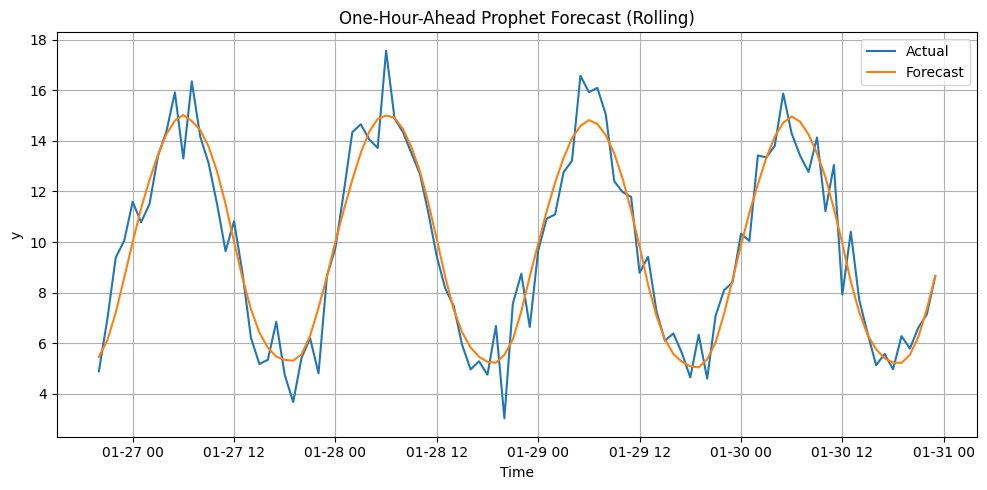

In [82]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate toy data
np.random.seed(42)
date_range = pd.date_range(start='2022-01-01', periods=24*30, freq='H')  # 30 days hourly
y_values = 10 + 5 * np.sin(2 * np.pi * date_range.hour / 24) + np.random.normal(0, 1, len(date_range))
toy_df = pd.DataFrame({'ds': date_range, 'y': y_values})

# Step 2: Rolling forecast setup
n_forecasts = 100  # last 100 time steps
results = []
errors = []

for i in range(len(toy_df) - n_forecasts, len(toy_df)):
    t_predict = toy_df['ds'].iloc[i]
    t_cutoff = t_predict - pd.Timedelta(hours=1)

    df_train = toy_df[toy_df['ds'] <= t_cutoff].copy()

    model = Prophet(daily_seasonality=True)
    model.fit(df_train)

    future = model.make_future_dataframe(periods=1, freq='H')
    forecast = model.predict(future)

    y_hat = forecast[forecast['ds'] == t_predict]['yhat'].values[0]
    y_true = toy_df[toy_df['ds'] == t_predict]['y'].values[0]

    results.append((t_predict, y_true, y_hat))
    errors.append((y_true - y_hat) ** 2)

# Step 3: Evaluation
results_df = pd.DataFrame(results, columns=['ds', 'y_true', 'y_pred'])
mse = np.mean(errors)
r2 = r2_score(results_df['y_true'], results_df['y_pred'])

print("Rolling One-Hour-Ahead Forecast Evaluation")
print("MSE:", mse)
print("R²:", r2)

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(results_df['ds'], results_df['y_true'], label='Actual')
plt.plot(results_df['ds'], results_df['y_pred'], label='Forecast')
plt.title('One-Hour-Ahead Prophet Forecast (Rolling)')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


23:54:25 - cmdstanpy - INFO - Chain [1] start processing
23:55:58 - cmdstanpy - INFO - Chain [1] done processing


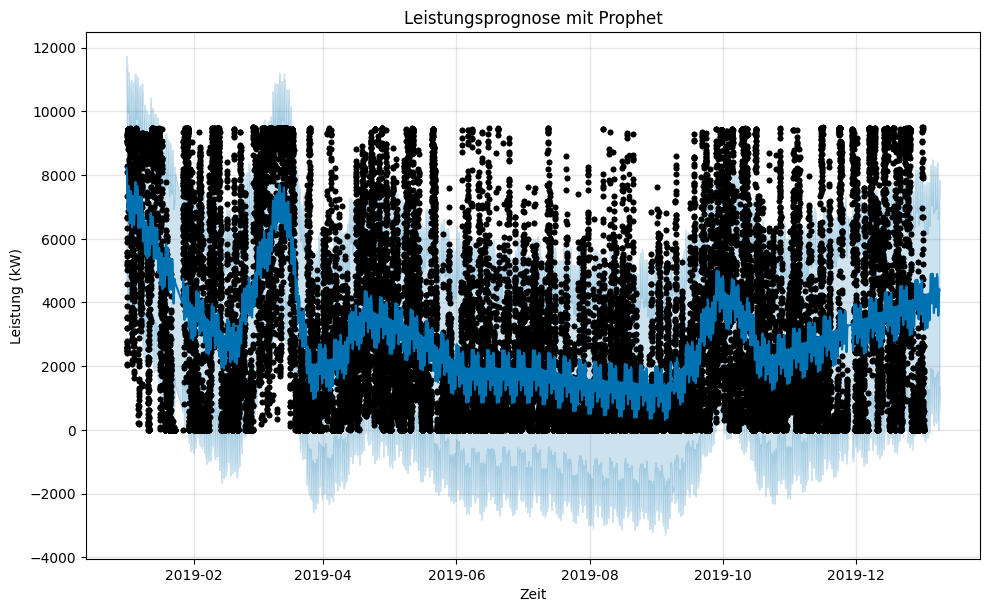

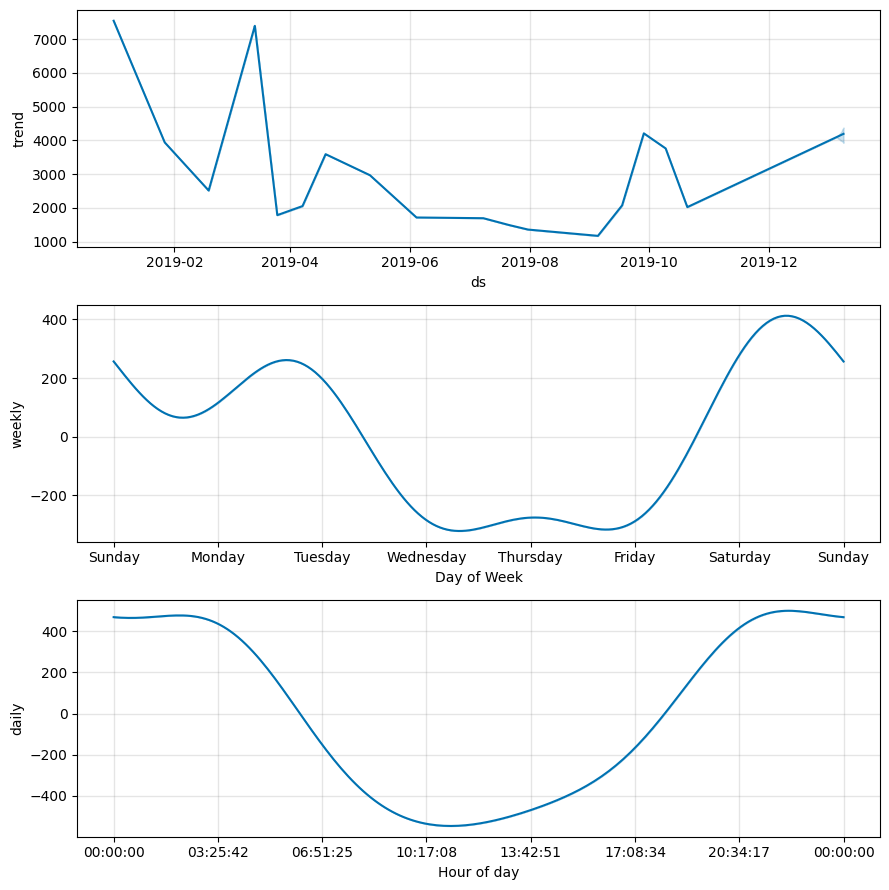

In [83]:
# 1. Installation (nur beim ersten Mal nötig)
# pip install prophet

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 2. CSV-Datei laden
df = pd.read_csv("data.csv")

# 3. Vorbereitung für Prophet
df_prophet = df[['time', 'power']].copy()
df_prophet.dropna(subset=['power'], inplace=True)
df_prophet.rename(columns={'time': 'ds', 'power': 'y'}, inplace=True)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# 4. Prophet-Modell trainieren
model = Prophet()
model.fit(df_prophet)

# 5. Prognose für 7 Tage (15-Minuten-Takt = 96 Punkte pro Tag)
future = model.make_future_dataframe(periods=96*7, freq='15min')
forecast = model.predict(future)

# 6. Plot der Prognose
model.plot(forecast)
plt.title("Leistungsprognose mit Prophet")
plt.xlabel("Zeit")
plt.ylabel("Leistung (kW)")
plt.show()

# 7. (Optional) Komponenten anzeigen
model.plot_components(forecast)
plt.show()


In [84]:
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Merge actual and predicted values based on timestamp
df_merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds')

# Step 2: Calculate MSE and R²
mse = mean_squared_error(df_merged['y'], df_merged['yhat'])
r2 = r2_score(df_merged['y'], df_merged['yhat'])

print("📉 Mean Squared Error (MSE):", mse)
print("📈 R² Score:", r2)


📉 Mean Squared Error (MSE): 6552528.375140661
📈 R² Score: 0.27814470486560594
